In [1]:
import numpy as np

In [1]:
import kdsource as kds

In [3]:
import os 

os.environ['PATH'] += "/home/jorobledo/Documents/Docencia/arfitec/KDSource/bin"

In [9]:
!../KDSource/bin/ssv2mcpl 'tracks' 'samples'

ssv_open_file: Opened file "tracks":
MCPL: Attempting to compress file samples.mcpl with gzip
MCPL: Succesfully compressed file into samples.mcpl.gz
Created samples.mcpl.gz


In [11]:
plist = kds.PList('samples.mcpl.gz')

Using existing file samples.mcpl.gz
sum_weights = 223.0
p2 = 223.0
N = 223
N_eff = 223.0


In [17]:
# Geometry: define changes of variables
E0=10
geom = kds.Geometry([kds.geom.Lethargy(E0),
                     kds.geom.SurfXY(),
                     kds.geom.Isotrop()])

# Create KDSource
s = kds.KDSource(plist, geom)

In [23]:
# We set more importance to the energy
var_importance = [3,1,1,1,1,1]

# Calculate scaling as std / var_imp

parts, ws = s.plist.get(N=-1)
scaling = s.geom.std(parts=parts)
scaling /= var_importance

$N=-1$ means that all particles in the list will be used. 

In [24]:
N=-1

# Optimization methods

#### Silvermann's Rule

In [25]:
s.bw_method = "silv"
s.fit(N, scaling=scaling)

Using 223 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[1.16255925 0.39540726 0.39794341 0.1150088  0.1150088  0.1150088 ]]


## Saving source file

In [26]:
xmlfile = 'source.xml'
s.save(xmlfile)

Successfully saved parameters file source.xml


'source.xml'

## Sampling new particles

In [27]:
n_new_particles = 1e3

!../KDSource/bin/kdtool resample "source.xml" -o "sample" -n $n_new_particles

Reading xmlfile source.xml...
Done.
Resampling...
MCPL: Attempting to compress file sample.mcpl with gzip
MCPL: Succesfully compressed file into sample.mcpl.gz
Successfully sampled 1000 particles.


In [28]:
import matplotlib.pyplot as plt

In [29]:
import mcpl

In [30]:
# Histogram of MCPL particle list
def mcpl_hist(mcplfile, var, bins, part0=None, part1=None, **kwargs):
    pl = mcpl.MCPLFile(mcplfile)
    hist = np.zeros(len(bins)-1)
    I = 0
    for pb in pl.particle_blocks:
        parts = np.stack((pb.ekin,pb.x,pb.y,pb.z,pb.ux,pb.uy,pb.uz), axis=1)
        mask1 = np.ones(len(parts), dtype=bool)
        if part0 is not None:
            mask1 = np.logical_and.reduce(part0 <= parts, axis=1)
        mask2 = np.ones(len(parts), dtype=bool)
        if part1 is not None:
            mask2 = np.logical_and.reduce(parts <= part1, axis=1)
        mask = np.logical_and(mask1, mask2)
        data = parts[mask][:,var]
        hist += np.histogram(data, bins=bins, weights=pb.weight[mask], **kwargs)[0]
        I += np.sum(pb.weight)
    hist /= I
    hist /= (bins[1:]-bins[:-1])
    return hist

In [32]:
import numpy as np

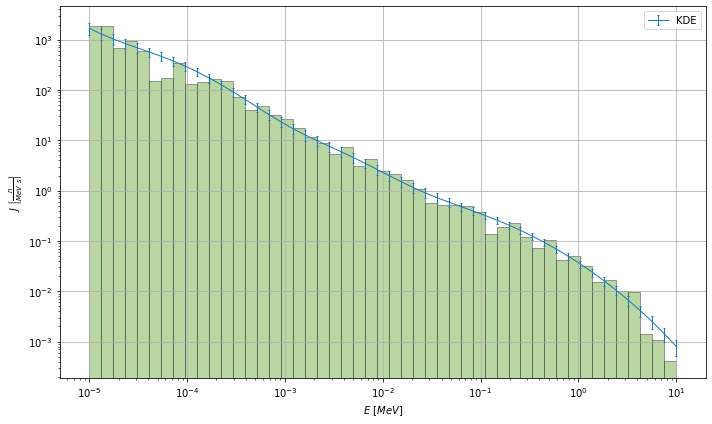

In [43]:
plt.figure(figsize=(10,6))
EE = np.logspace(-5,1,50)
fig, scores = s.plot_E(EE)
hist = mcpl_hist("sample.mcpl.gz", 0, EE)
widths = (EE[1:]-EE[:-1])
plt.bar(EE[:-1], hist, width=widths, align="edge", linewidth=.5, ec="k",
        fc="#9CC57C", alpha=.7, label="Resampled")
plt.show()